# Flight Price Prediction

https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction/data

In [26]:
# importando a base de dados
import pandas as pd

economy_df = pd.read_csv('economy.csv')
business_df = pd.read_csv('business.csv')

In [27]:
# integrando os dois csv
economy_df['class'] = 'Economy'
business_df['class'] = 'Business'

df = pd.concat([economy_df, business_df], ignore_index=True)
df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",Economy
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953",Economy
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956",Economy
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955",Economy
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955",Economy


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300261 entries, 0 to 300260
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        300261 non-null  object
 1   airline     300261 non-null  object
 2   ch_code     300261 non-null  object
 3   num_code    300261 non-null  int64 
 4   dep_time    300261 non-null  object
 5   from        300261 non-null  object
 6   time_taken  300261 non-null  object
 7   stop        300261 non-null  object
 8   arr_time    300261 non-null  object
 9   to          300261 non-null  object
 10  price       300261 non-null  object
 11  class       300261 non-null  object
dtypes: int64(1), object(11)
memory usage: 27.5+ MB


In [29]:
# Concatena 'ch_code' and 'num_code' em nova coluna 'flight'
df['flight'] = df['ch_code'] + '-' + df['num_code'].astype(str)
df.drop(['ch_code', 'num_code'], axis=1, inplace=True)

In [30]:
# converte preço para float
df['price'] = df['price'].str.replace(',', '').astype(float)

In [31]:
# converte data para datetime
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
inicio = pd.to_datetime('11-02-2022', format='%d-%m-%Y')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300261 entries, 0 to 300260
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        300261 non-null  datetime64[ns]
 1   airline     300261 non-null  object        
 2   dep_time    300261 non-null  object        
 3   from        300261 non-null  object        
 4   time_taken  300261 non-null  object        
 5   stop        300261 non-null  object        
 6   arr_time    300261 non-null  object        
 7   to          300261 non-null  object        
 8   price       300261 non-null  float64       
 9   class       300261 non-null  object        
 10  flight      300261 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(9)
memory usage: 25.2+ MB


In [33]:
df['days_left'] = (df['date'] - inicio).dt.days + 1
df.drop('date', axis=1, inplace=True)

In [34]:
# converte duração para horas
def convert_time_to_hours(time_str):
    if 'h' in time_str:
        parts = time_str.split('h')
        hours = float(parts[0].strip())
        minutes = 0
        if 'm' in parts[1] and parts[1].strip().split('m')[0].strip() != '':
            minutes = int(parts[1].strip().split('m')[0].strip())
        return round(hours + minutes / 60, 2)
    else:
        return round(float(time_str), 2)

df['duration'] = df['time_taken'].apply(convert_time_to_hours)
df.drop('time_taken', axis=1, inplace=True)

In [35]:
'''0 - 5 (late night)
5 - 8 (early morning)
8 - 12 (morning)
12 - 17 (afternoon)
17 - 20 (evening)
20 - 23 (night)
23 - 0 (late night)'''

df['dep_time'] = pd.to_datetime(df['dep_time'], format='%H:%M')
df['arr_time'] = pd.to_datetime(df['arr_time'], format='%H:%M')

def time_categorization(times):
    categories = pd.cut(times.dt.hour*60 + times.dt.minute, 
                        bins=[0, 300, 480, 720, 1020, 1200, 1380, 1440],
                        labels=['Late Night', 'Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Late Night'],
                        right=False, ordered=False)
    categories = categories.where(categories != 'Late Night', other=pd.NA)
    categories.fillna(method='bfill', inplace=True)
    return categories.astype(str)

df['dep_time'] = time_categorization(df['dep_time'])
df['arr_time'] = time_categorization(df['arr_time'])


/tmp/ipykernel_276313/3189035850.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  categories.fillna(method='bfill', inplace=True)
/tmp/ipykernel_276313/3189035850.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  categories.fillna(method='bfill', inplace=True)


In [36]:
df['stop'] = df['stop'].str.replace(r'\s+', '', regex=True)
def convert_stops(stop_description):
    if 'non-stop' in stop_description:
        return 0
    num_part = ''.join(filter(str.isdigit, stop_description.split('-')[0]))
    return int(num_part)

df['stop'] = df['stop'].apply(convert_stops)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300261 entries, 0 to 300260
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   airline    300261 non-null  object 
 1   dep_time   300261 non-null  object 
 2   from       300261 non-null  object 
 3   stop       300261 non-null  int64  
 4   arr_time   300261 non-null  object 
 5   to         300261 non-null  object 
 6   price      300261 non-null  float64
 7   class      300261 non-null  object 
 8   flight     300261 non-null  object 
 9   days_left  300261 non-null  int64  
 10  duration   300261 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 25.2+ MB


In [38]:
df.drop_duplicates(inplace=True)

In [39]:
# Análise Exploratória

import matplotlib.pyplot as plt 
import seaborn as sns

df.describe(include='all')

,airline,dep_time,from,stop,arr_time,to,price,class,flight,days_left,duration
count,300259,300259,300259,300259.000000,300259,300259,300259.000000,300259,300259,300259.000000,300259.000000
unique,8,5,6,NaN,5,6,NaN,2,1569,NaN,NaN
top,Vistara,Morning,Delhi,NaN,Night,Mumbai,NaN,Economy,UK-706,NaN,NaN
freq,127859,76509,61343,NaN,77108,59107,NaN,206772,3235,NaN,NaN
mean,NaN,NaN,NaN,0.924212,NaN,NaN,20883.800386,NaN,NaN,26.004529,12.217742
std,NaN,NaN,NaN,0.398189,NaN,NaN,22695.962230,NaN,NaN,13.560967,7.192948
min,NaN,NaN,NaN,0.000000,NaN,NaN,1105.000000,NaN,NaN,1.000000,0.830000
25%,NaN,NaN,NaN,1.000000,NaN,NaN,4783.000000,NaN,NaN,15.000000,6.750000
50%,NaN,NaN,NaN,1.000000,NaN,NaN,7425.000000,NaN,NaN,26.000000,11.250000
75%,NaN,NaN,NaN,1.000000,NaN,NaN,42521.000000,NaN,NaN,38.000000,16.170000


<Axes: xlabel='count', ylabel='airline'>

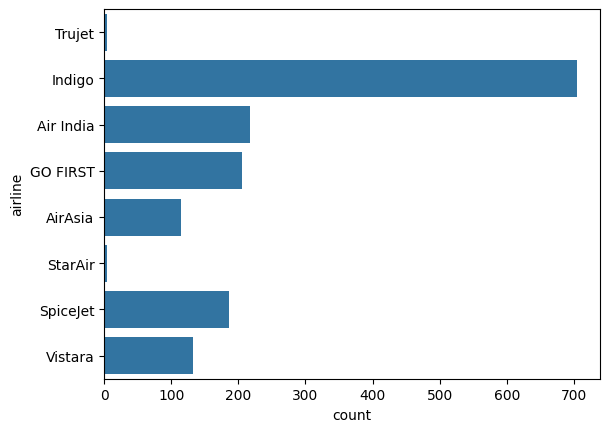

In [40]:
# Qual companhia aerea tem mais voos?

df1 = df.groupby(['flight', 'airline'], as_index=False).count()
sns.countplot(df1['airline'])

<Axes: xlabel='airline', ylabel='price'>

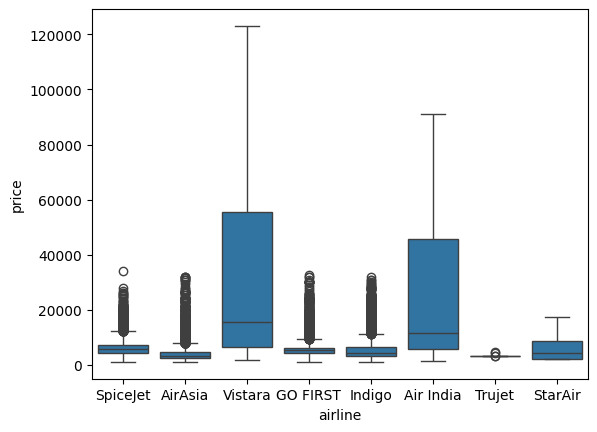

In [41]:
# o preço varia por companhia aerea?

sns.boxplot(x=df['airline'], y=df['price'])

<Axes: xlabel='days_left', ylabel='price'>

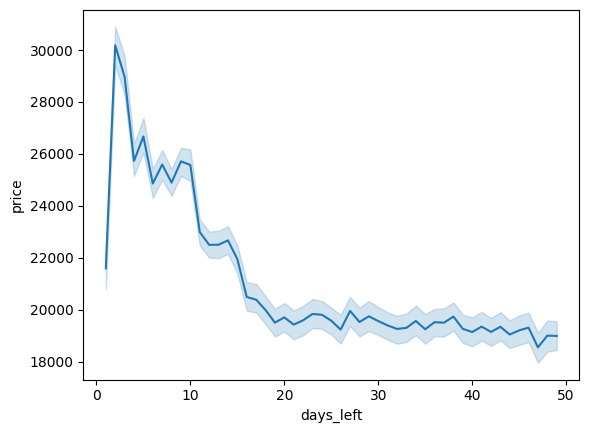

In [42]:
# como varia o preço com relação aos dias que faltam

sns.lineplot(data=df, x='days_left', y='price')

In [43]:
# Quantas combinações distintas de voo (com base em número de voos, companhias aéreas e classes) existem entre cada par de cidades de origem e destino?
df.groupby(['flight','from','to','airline','class'],as_index=False).count().groupby(['from','to'],as_index=False)['flight'].count().head(10)

,from,to,flight
0,Bangalore,Chennai,106
1,Bangalore,Delhi,227
2,Bangalore,Hyderabad,135
3,Bangalore,Kolkata,171
4,Bangalore,Mumbai,175
5,Chennai,Bangalore,69
6,Chennai,Delhi,105
7,Chennai,Hyderabad,82
8,Chennai,Kolkata,110
9,Chennai,Mumbai,94


In [44]:
# Qual é o preço médio das passagens por companhia aérea entre cada par de cidades de origem e destino?
df.groupby(['airline','from','to'],as_index=False)['price'].mean().head(10)

,airline,from,to,price
0,Air India,Bangalore,Chennai,26765.567702
1,Air India,Bangalore,Delhi,20699.099886
2,Air India,Bangalore,Hyderabad,23395.956912
3,Air India,Bangalore,Kolkata,29105.826259
4,Air India,Bangalore,Mumbai,25625.530802
5,Air India,Chennai,Bangalore,29786.121490
6,Air India,Chennai,Delhi,20399.856369
7,Air India,Chennai,Hyderabad,27043.660615
8,Air India,Chennai,Kolkata,29016.375602
9,Air India,Chennai,Mumbai,23188.272059


In [45]:
# variaveis categoricas

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

In [46]:
df.head()

,airline,dep_time,from,stop,arr_time,to,price,class,flight,days_left,duration
0,4,2,2,0,4,5,5953.0,1,1416,1,2.17
1,4,1,2,0,3,5,5953.0,1,1395,1,2.33
2,1,3,2,0,1,5,5956.0,1,1217,1,2.17
3,7,3,2,0,0,5,5955.0,1,1567,1,2.25
4,7,3,2,0,3,5,5955.0,1,1557,1,2.33


<Axes: >

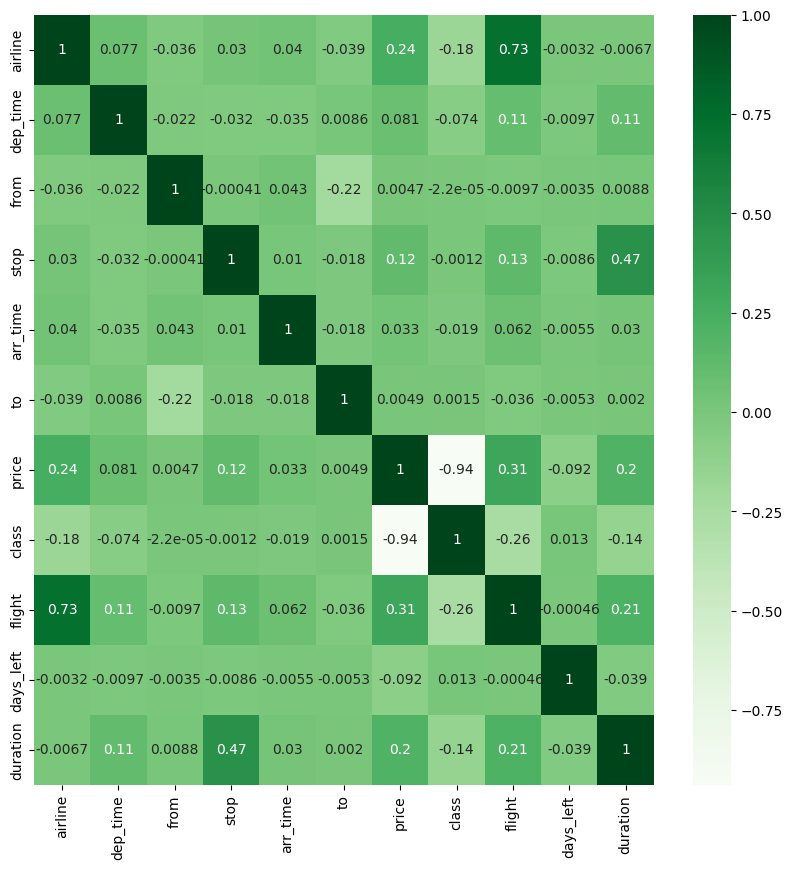

In [47]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, cmap='Greens')

In [48]:
x = df.drop(['price'], axis=1)
y = df['price']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [49]:
# normalização
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test) 

In [50]:

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

lr = LinearRegression()
tree = DecisionTreeRegressor()
rf = RandomForestRegressor(n_estimators=100)
knn = KNeighborsRegressor(n_neighbors=5)

models = [lr, tree, rf, knn]

for model in models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print("Modelo: ", model)
    print("MAE: ", round(metrics.mean_absolute_error(y_test, y_pred), 2))
    print("MSE: ", round(metrics.mean_squared_error(y_test, y_pred), 2))
    print("R2_score: ", round(metrics.r2_score(y_test, y_pred), 4))

    print('-------------------')


Modelo:  LinearRegression()
MAE:  4567.66
MSE:  48097209.56
R2_score:  0.9067
-------------------
Modelo:  DecisionTreeRegressor()
MAE:  899.85
MSE:  8554830.27
R2_score:  0.9834
-------------------
Modelo:  RandomForestRegressor()
MAE:  875.45
MSE:  5301190.06
R2_score:  0.9897
-------------------
Modelo:  KNeighborsRegressor()
MAE:  1783.34
MSE:  13645305.83
R2_score:  0.9735
-------------------
